In [1]:
# import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# sys.path.append("/home/nmf8dm/research/PARCv2/code")
from parc.data.data_em import *

2024-07-15 19:41:36.624971: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = DataEnergeticMaterials()

# x, u = data.clip_raw_data(dataset_range = (100,130), dir_dataset="/scratch/pdy2bw/single_void_new_clip_testing/", dim_reduce=8)
# x_norm, u_norm = data.data_normalization(x,3), data.data_normalization(u,2)

###########
# OR — temporary below for data from Joseph which was already run through clip_raw_data

path = "/scratch/pdy2bw/class5_mesoscale_processed/"

x = np.float32(np.load(path + "mesoscale_x.npy"))
u = np.float32(np.load(path + "mesoscale_u.npy"))

#resize for U-net: [:, X, Y, :] X and Y need to be divisible by 16
x = x[:, :-10, :,:]
u = u[:, :-10, :,:]


x_norm, u_norm = data.data_normalization(x,3), data.data_normalization(u,2)

In [78]:
x.shape

(480, 160, 256, 6)

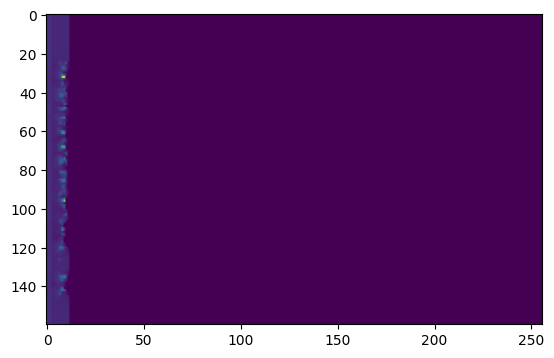

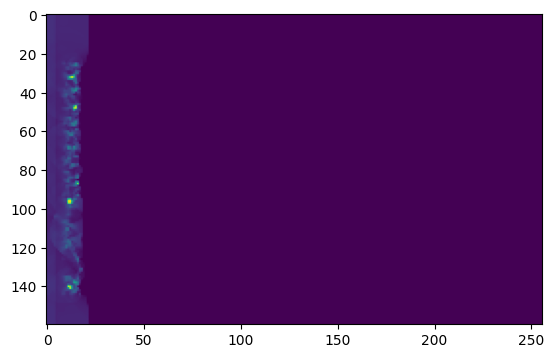

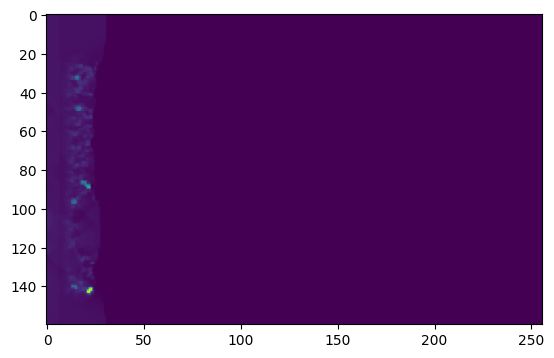

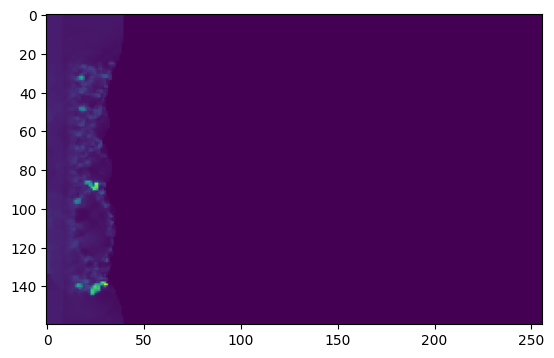

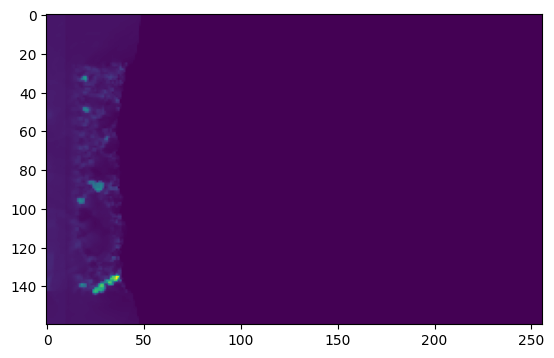

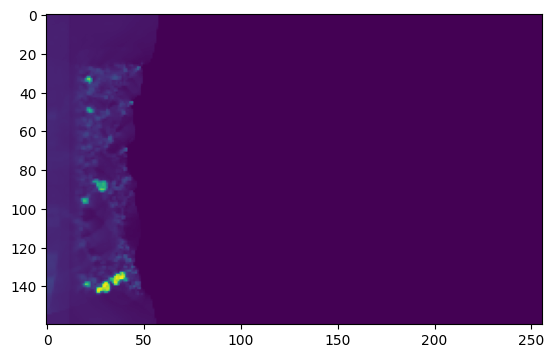

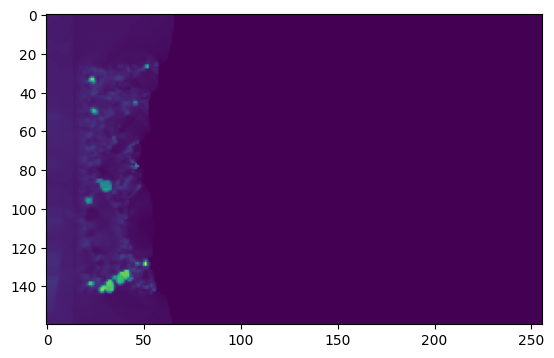

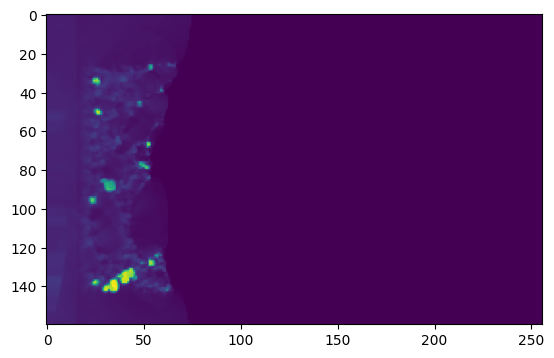

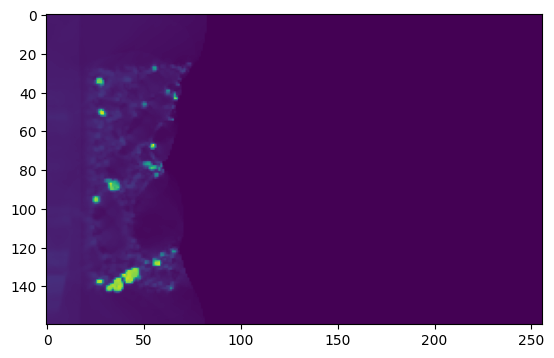

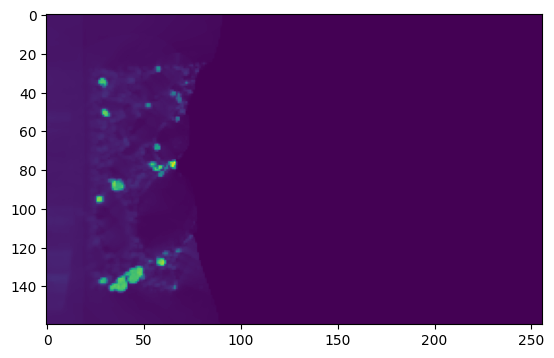

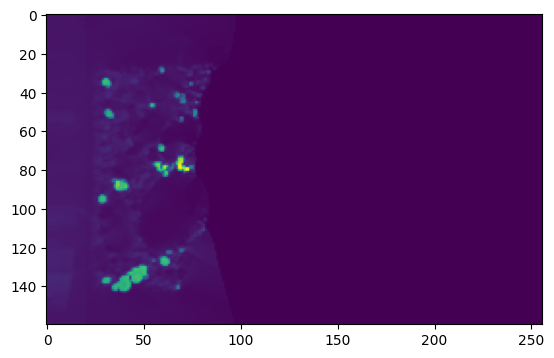

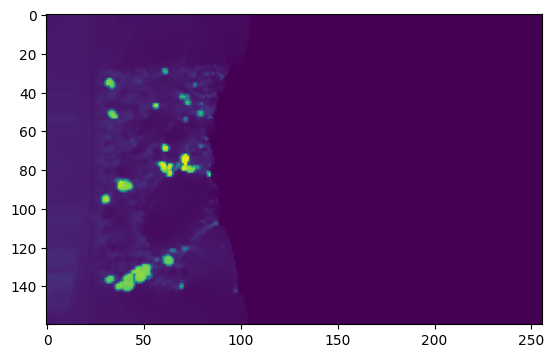

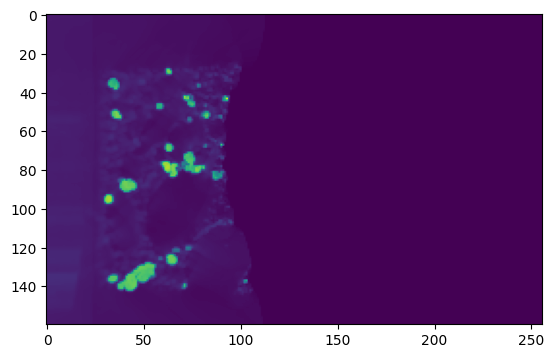

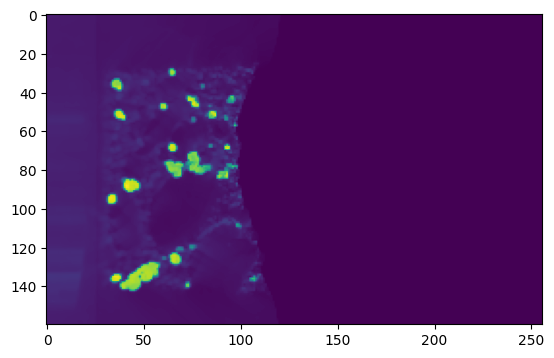

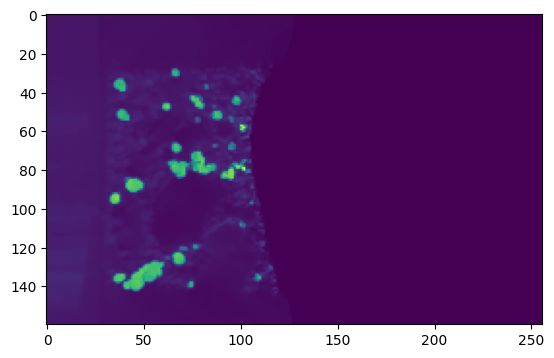

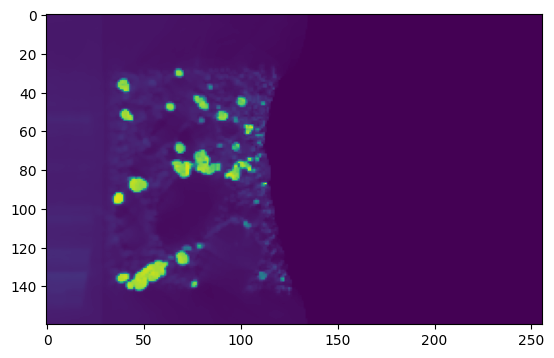

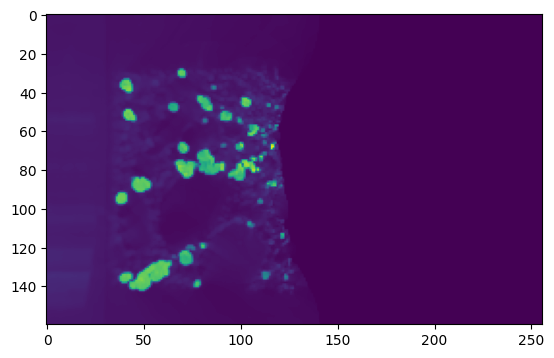

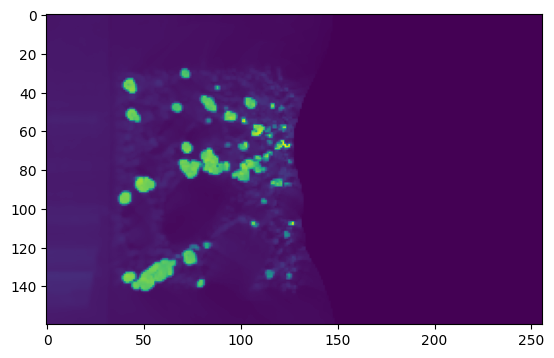

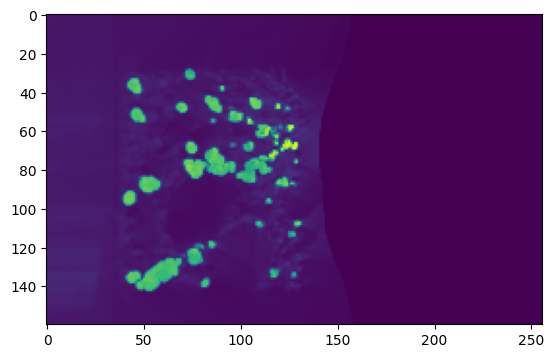

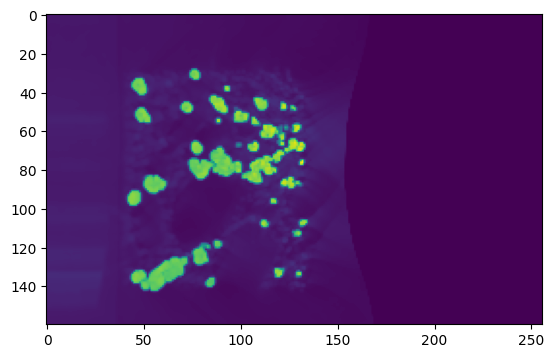

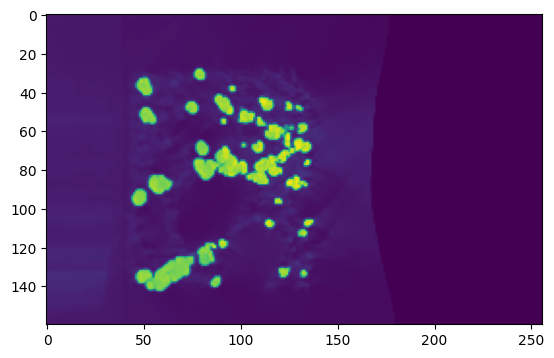

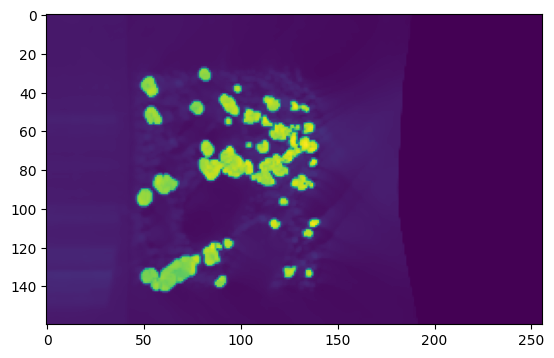

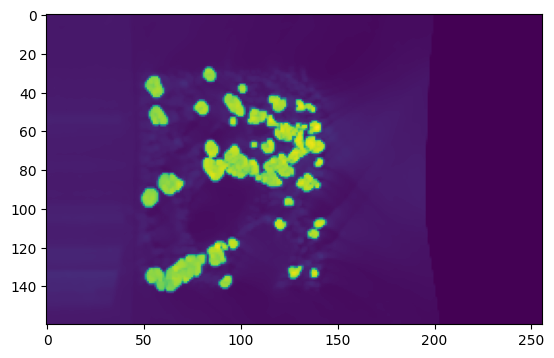

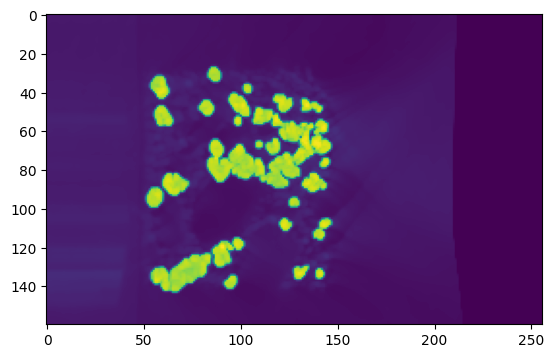

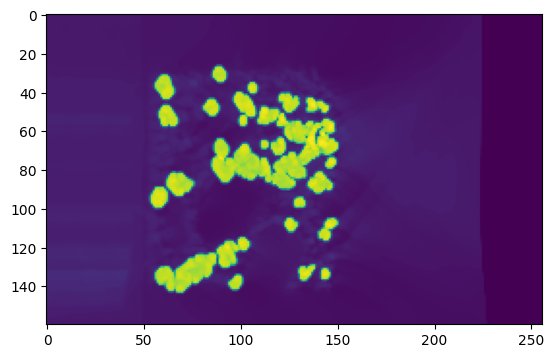

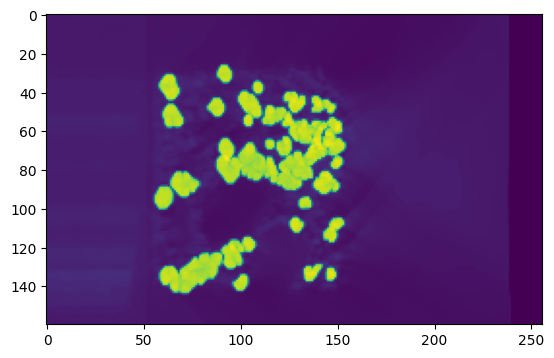

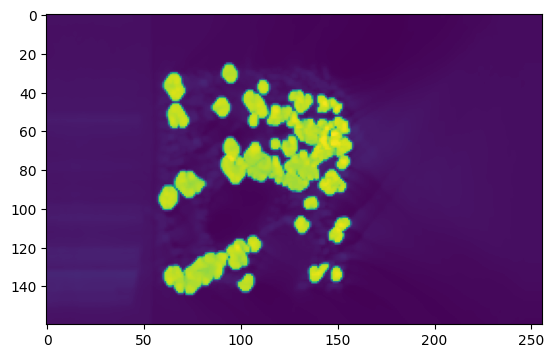

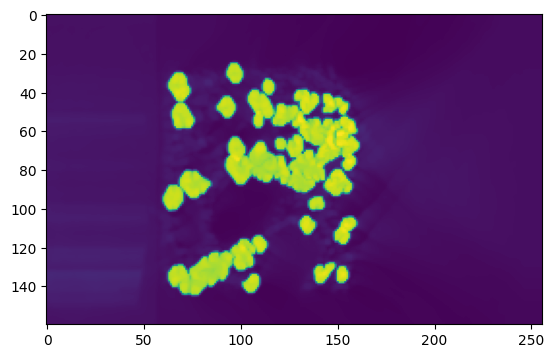

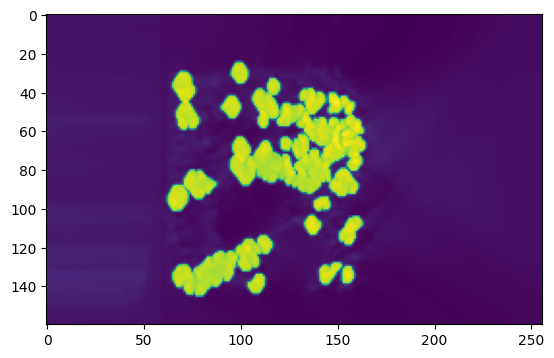

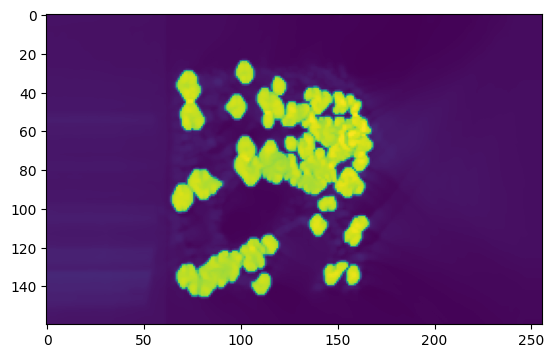

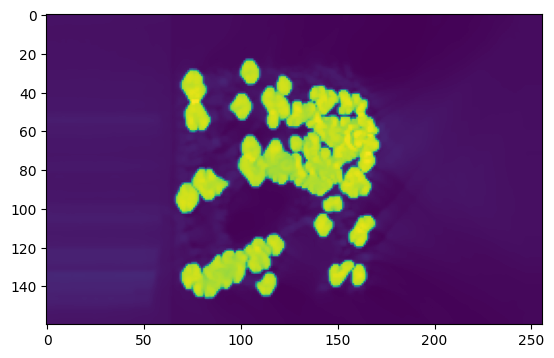

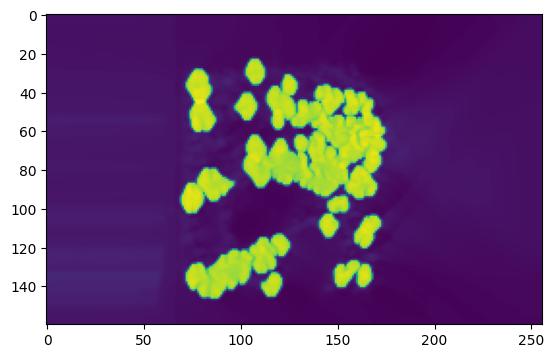

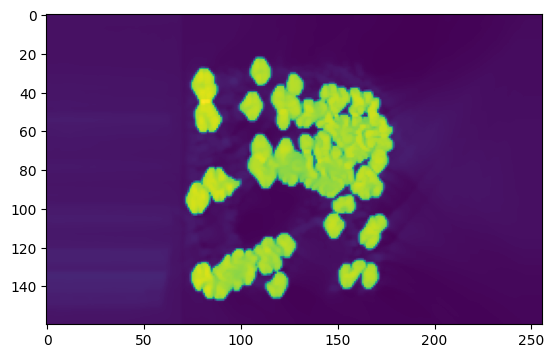

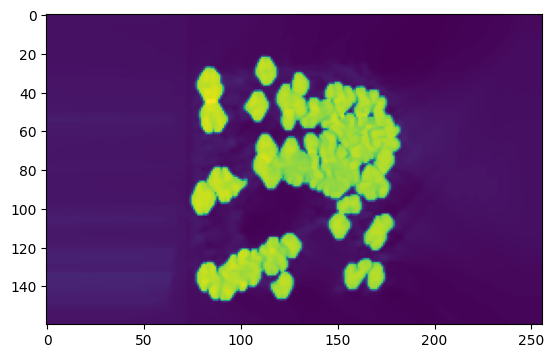

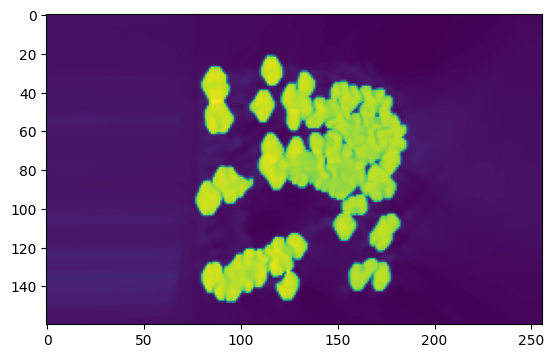

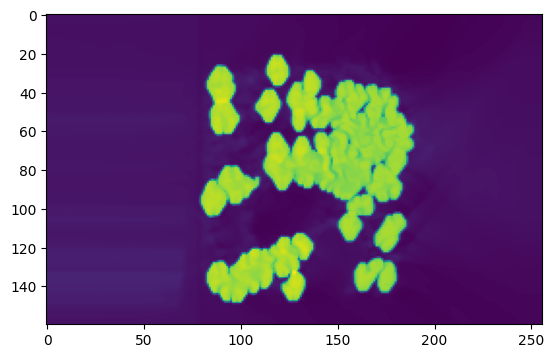

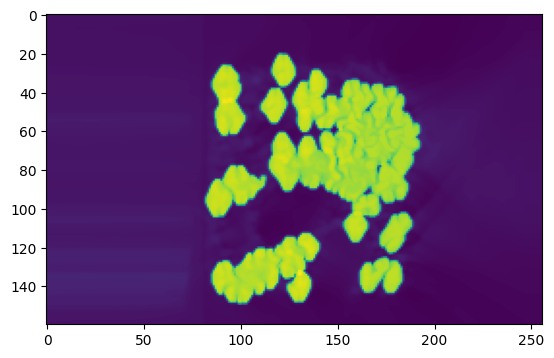

In [88]:
for i in range(0,37):
    plt.imshow(x[i,:,:,0])
    plt.show()

In [3]:
# x_in = tf.data.Dataset.from_tensor_slices( (x_norm[0][:,:,:,:3], u_norm[0][:,:,:,:2]) )
# y_in = tf.data.Dataset.from_tensor_slices( (x_norm[0][:,:,:,-3:], u_norm[0][:,:,:,-2:]) )

x_in = x_norm[0][..., :3]
u_in = u_norm[0][..., :2]

x_out = x_norm[0][..., 3:]
u_out = u_norm[0][..., 2:]

print( x_in.shape, u_in.shape ) 
print( x_out.shape, u_out.shape ) 

(480, 160, 256, 3) (480, 160, 256, 2)
(480, 160, 256, 3) (480, 160, 256, 2)


In [67]:
class spade_unit(tf.keras.layers.Layer):
    def __init__(self, n_feats=128):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(n_feats, 3, padding='same', activation='relu')
        self.conv_gamma = tf.keras.layers.Conv2D(n_feats, 3, padding='same')
        self.conv_beta = tf.keras.layers.Conv2D(n_feats, 3, padding='same')
        self.epsilon = 1e-5

    def call(self, inputs):
        x, mask = inputs[0], inputs[1]
        
        # mask = tf.image.resize(mask, x.shape[1:3], method='nearest')
        mask = self.conv(mask)
        
        gamma = self.conv_gamma(mask)
        beta = self.conv_beta(mask)
        
        mean, var = tf.nn.moments(x, axes=(0,1,2), keepdims=True)
        std = tf.sqrt( tf.math.add(var, self.epsilon) )
        
        normalized = tf.math.divide( tf.math.subtract(x, mean), std)
        normalized = tf.math.add( tf.math.multiply(gamma, normalized ), beta )
        return normalized   
    
class resnet_unit(tf.keras.layers.Layer):
    def __init__(self, n_feats=128):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(n_feats, 1, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(n_feats, 1, padding='same')
        
    def call(self, inputs):
        x = tf.keras.layers.ReLU()(self.conv1(inputs))
        x = self.conv2(x)
        out = tf.keras.layers.ReLU()(tf.math.add(inputs, x))
        return out
            
class integrator_unit(tf.keras.layers.Layer):
    def __init__(self, n_feats=128, n_out=1):
        super().__init__()
        
        self.resnet1 = resnet_block(n_feats=n_feats, n_blocks=0)
        self.resnet2 = resnet_block(n_feats=n_feats, n_blocks=2)
        self.style = spade_block(n_feats=n_feats)
        self.conv = tf.keras.layers.Conv2D(n_out, 1, padding='same')
    
    def call(self, inputs):
        x, mask = inputs[0], inputs[1]
        
        resnet_out = self.resnet1(x)
        style_vector = self.style(resnet_out)
        resnet_out = self.resnet2(style_vector)
        out = self.conv(resnet_out)
        return out

In [68]:
# phong calls it a "style vector", ref: spade_generator_unit
class spade_block(tf.keras.layers.Layer): 
    def __init__(self, n_feats=128):
        super().__init__()
        self.spade1 = spade_unit(n_feats=n_feats)
        self.spade2 = spade_unit(n_feats=n_feats)
        self.spade3 = spade_unit(n_feats=n_feats)
        
        self.conv1 = tf.keras.layers.Conv2D(n_feats, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(n_feats, 3, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(n_feats, 3, padding='same')
        
    def call(self, inputs):
        x, mask = inputs[0], inputs[1]
        x = tf.keras.layers.GaussianNoise(0.05)(x)
        
        s1 = self.conv1( tf.keras.layers.LeakyReLU(0.2)( self.spade1( [x, mask] ) ) )
        s2 = self.conv2( tf.keras.layers.LeakyReLU(0.2)( self.spade2( [s1, mask] ) ) )    
        s_skip = self.conv3( tf.keras.layers.LeakyReLU(0.2)( self.spade3( [x, mask] ) ) )
        
        out = tf.keras.layers.add( [s2, s_skip] )
        return out    

 
    
class resnet_block(tf.keras.layers.Layer):
    def __init__(self, n_feats=128, n_blocks=2):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(n_feats, 1, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(n_feats, 1, padding='same', activation='relu')
        
        ## resnet unit, which could repeat
        self.n_blocks = n_blocks
        self.resnet_units = [None] * n_blocks
        for i in range(n_blocks):
            self.resnet_units[i] = resnet_unit(n_feats)
        
    # tag: didn't indluce pooling
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        
        for i in range(self.n_blocks):
            x = self.resnet_units[i](x)
        return x        

In [69]:
class style_map(tf.keras.layers.Layer):
    def __init__(self, n_feats=128, n_out=1): 
        super().__init__()
        self.style = spade_block(n_feats)
        self.resnet = resnet_block(n_feats)
        self.conv = tf.keras.layers.Conv2D(n_out, n_out, padding='same') # bug: output dimension     
        
    def call(self, inputs):
        x, mask = inputs[0], inputs[1]
        
        style_vector = self.style( [x, mask] )
        resnet_out = self.resnet(style_vector)
        conv_out = self.conv(resnet_out)
        return conv_out    
    
class advection(tf.keras.layers.Layer):
    def __init__(self): 
        super().__init__()
        
    def call(self, inputs):
        x, u = inputs[0], inputs[1]
        dy, dx = tf.image.image_gradients(x)
        spatial_deriv = tf.concat( [dy, dx], axis=-1 )
        advect = tf.reduce_sum( tf.multiply( spatial_deriv, u ), axis=-1, keepdims=True )
        return advect

class diffusion(tf.keras.layers.Layer):
    def __init__(self): 
        super().__init__()
        
    def call(self, inputs):
        dy, dx = tf.image.image_gradients(inputs)
        dyy, _ = tf.image.image_gradients(dy)
        _, dxx = tf.image.image_gradients(dx)
        laplacian = tf.math.add( dyy, dxx )
        return laplacian

In [70]:
class differentiator(tf.keras.layers.Layer):
    def __init__(self, n_feats=128): 
        super().__init__()
        self.unet = unet()
        
        self.T_adv = advection()
        self.P_adv = advection()
        self.M_adv = advection()
        self.VX_adv = advection()
        self.VY_adv = advection()
        self.diffusion = diffusion()

        self.T_map = style_map(n_feats)
        self.P_map = style_map(n_feats)
        self.M_map = style_map(n_feats) 
        self.V_map = style_map(n_feats, n_out=2)
        
    def call(self, inputs):
        T_in = inputs[..., 0:1]
        P_in = inputs[..., 1:2]
        M_in = inputs[..., 2:3]
        Vx_in = inputs[..., 3:4]
        Vy_in = inputs[..., 4:5]
        U_in = tf.concat( [Vx_in, Vy_in], axis=-1 )
        
        feature_map = self.unet(inputs)
        
        T_adv = self.T_adv( [T_in, U_in] )
        T_diff = self.diffusion( T_in )
        T = tf.concat( [T_adv, T_diff], axis=-1 )
        T_dot = self.T_map( [feature_map, T] )
        
        P_adv = self.P_adv( [P_in, U_in] )
        P_dot = self.P_map( [feature_map, P_adv] )
        
        M_adv = self.M_adv( [M_in, U_in] )
        M_dot = self.M_map( [feature_map, M_adv] )
        
        VX_adv = self.VX_adv( [Vx_in, U_in] )
        VY_adv = self.VY_adv( [Vy_in, U_in] )
        V_adv = tf.concat( [VX_adv, VY_adv], axis=-1 )
        V_dot = self.V_map( [feature_map, V_adv] )
        
        out = tf.concat( [T_dot, P_dot, M_dot, V_dot], axis=-1 )
        return out
    
class integrator(tf.keras.layers.Layer):
    def __init__(self, n_feats=128):
        super().__init__()
        self.T_int = integrator_unit(n_feats=n_feats)
        self.P_int = integrator_unit(n_feats=n_feats)
        self.M_int = integrator_unit(n_feats=n_feats)
        self.V_int = integrator_unit(n_feats=n_feats, n_out=2)
        
    def call(self, inputs):
        x_dot, u_dot, x, u = inputs[0], inputs[1], inputs[2], inputs[3]
        
        T_next = self.T_int( x[..., 0:1], x_dot[..., 0:1] )
        P_next = self.P_int( x[..., 1:2], x_dot[..., 1:2] )
        M_next = self.M_int( x[..., 2:3], x_dot[..., 2:3] )
        V_next = self.V_int( u[..., 4:6], u_dot[..., 4:6] ) # tag: double check
        X_next = keras.concat( [T_next, P_next, M_next], axis=-1 )        
        
        return tf.convert_to_tensor(X_next), tf.convert_to_tensor(V_next)

In [71]:
# bug: no padding in initial model
class unet(tf.keras.layers.Layer):
    def __init__(self, n_feats=64, n_feature_map=128): 
        super().__init__()
        self.d1c1 = tf.keras.layers.Conv2D(n_feats, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.d1c2 = tf.keras.layers.Conv2D(n_feats, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same')
        
        self.d2c0 = tf.keras.layers.MaxPooling2D(2,2)
        self.d2c1 = tf.keras.layers.Conv2D(n_feats * 2, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.d2c2 = tf.keras.layers.Conv2D(n_feats * 2, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.d3c0 = tf.keras.layers.MaxPooling2D(2,2)
        self.d3c1 = tf.keras.layers.Conv2D(n_feats * 4, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.d3c2 = tf.keras.layers.Conv2D(n_feats * 4, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )

        self.d4c0 = tf.keras.layers.MaxPooling2D(2,2)
        self.d4c1 = tf.keras.layers.Conv2D(n_feats * 8, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.d4c2 = tf.keras.layers.Conv2D(n_feats * 8, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.bottleneck_c0 = tf.keras.layers.MaxPooling2D(2,2)
        self.bottleneck_c1 = tf.keras.layers.Conv2D(n_feats * 16, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.bottleneck_c2 = tf.keras.layers.Conv2D(n_feats * 16, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.u4c0 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')
        self.u4c1 = tf.keras.layers.Conv2D(n_feats * 8, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.u4c2 = tf.keras.layers.Conv2D(n_feats * 8, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.u3c0 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')
        self.u3c1 = tf.keras.layers.Conv2D(n_feats * 4, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.u3c2 = tf.keras.layers.Conv2D(n_feats * 4, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.u2c0 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')
        self.u2c1 = tf.keras.layers.Conv2D(n_feats * 2, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.u2c2 = tf.keras.layers.Conv2D(n_feats * 2, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.u1c0 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')
        self.u1c1 = tf.keras.layers.Conv2D(n_feature_map, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.u1c2 = tf.keras.layers.Conv2D(n_feature_map, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
        self.r0 = tf.keras.layers.Conv2D(n_feature_map, 3, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        self.r1 = tf.keras.layers.Conv2D(n_feature_map, 1, activation=tf.keras.layers.LeakyReLU(0.2), padding='same' )
        
    def call(self, inputs):
        d1c1 = self.d1c1(inputs)
        d1c2 = self.d1c2(d1c1)
        
        d2c0 = self.d2c0(d1c2)
        d2c1 = self.d2c1(d2c0)
        d2c2 = self.d2c2(d2c1)
        
        d3c0 = self.d3c0(d2c2)
        d3c1 = self.d3c1(d3c0)
        d3c2 = self.d3c2(d3c1)

        d4c0 = self.d4c0(d3c2)
        d4c1 = self.d4c1(d4c0)
        d4c2 = self.d4c2(d4c1)
        
        bottleneck_c0 = self.bottleneck_c0(d4c2)
        bottleneck_c1 = self.bottleneck_c1(bottleneck_c0)
        bottleneck_c2 = self.bottleneck_c2(bottleneck_c1)
        
        u4c0 = self.u4c0(bottleneck_c2)
        u4c1 = self.u4c1(u4c0)
        u4c2 = self.u4c2(u4c1)
        
        u3c0 = self.u3c0(u4c2)
        u3_concat = tf.concat([u3c0, d3c2], axis=-1)
        u3c1 = self.u3c1(u3_concat)
        u3c2 = self.u3c2(u3c1)
        
        u2c0 = self.u2c0(u3c2)
        u2c1 = self.u2c1(u2c0)
        u2c2 = self.u2c2(u2c1)
        
        u1c0 = self.u1c0(u2c2)
        u1_concat = tf.concat([u1c0, d1c2], axis=-1)
        u1c1 = self.u1c1(u1_concat)
        u1c2 = self.u1c2(u1c1)
        
        r0 = self.r0(u1c2)
        feature_map = self.r1(r0)
        
        return feature_map

In [72]:
class parcV2(tf.keras.Model):
    def __init__(self, numerical_int=True, n_ts=36, n_step=1/40):
        super().__init__()
        self.differentiator = differentiator()
        self.integrator = integrator()
        self.numerical_int = numerical_int
        self.n_ts = n_ts
        self.n_step = n_step
        
    def call(self, inputs):        
        x_in, u_in = tf.cast( inputs[0], tf.float32 ), tf.cast( inputs[1], tf.float32 )
        data_in = tf.concat( [x_in, u_in], axis=-1 )
        
        x_preds = [None] * self.n_ts
        u_preds = [None] * self.n_ts
        for t in range(self.n_ts):
            data_in = tf.clip_by_value(data_in, 0., 1.)
            
            """ RK4 integration """ 
            k1 = self.differentiator(data_in)
            
            k2 = tf.math.add( data_in, tf.math.multiply( tf.math.multiply( self.n_step, 0.5 ), k1 ) )
            k2 = self.differentiator(k2)
            
            k3 = tf.math.add( data_in, tf.math.multiply( tf.math.multiply( self.n_step, 0.5 ), k2 ) )
            k3 = self.differentiator(k3)
            
            k4 = tf.math.add( data_in, tf.math.multiply( self.n_step, k3 ) )
            k4 = self.differentiator(k4)
            
            k1 = tf.math.divide( k1, 6 )
            k2 = tf.math.divide( k2, 3 )
            k3 = tf.math.divide( k3, 3 )
            k4 = tf.math.divide( k4, 6 )
            
            rk4_update = tf.math.add_n( [k1, k2, k3, k4] )
            data_in = tf.math.add( data_in, tf.math.multiply( self.n_step, rk4_update ) )

            x_preds[t] = data_in[..., :3]
            u_preds[t] = data_in[..., 3:]
        
        return tf.concat( x_preds, axis=-1 ), tf.concat( u_preds, axis=-1 )
            
            
    def train_step(self, data):
        data_in, y_true = data
        X_true, U_true = y_true
        
        X_true = tf.cast( X_true, tf.float32 )
        U_true = tf.cast( U_true, tf.float32 ) 
        
        with tf.GradientTape() as tape: 
            X_pred, U_pred = self(data_in)
            loss = tf.math.reduce_mean( tf.math.abs( tf.math.subtract( X_true, X_pred  ) ) ) + \
                tf.math.reduce_mean( tf.math.abs( tf.math.subtract( U_true, U_pred ) ) )
        
        trainable_weights = self.trainable_variables
        grads = tape.gradient( loss, trainable_weights )
        self.optimizer.apply_gradients( zip(grads, trainable_weights) )
        
        return {'loss' : loss}

In [80]:
x_in = x_norm[0][..., :3]
u_in = u_norm[0][..., :2]

x_out = x_norm[0][..., 3:]
u_out = u_norm[0][..., 2:]

print( x_in.shape, u_in.shape ) 
print( x_out.shape, u_out.shape ) 

(480, 160, 256, 3) (480, 160, 256, 2)
(480, 160, 256, 3) (480, 160, 256, 2)


In [81]:
dataset_input = tf.data.Dataset.from_tensor_slices( (x_in[...,:3], u_in[...,:2]) )
dataset_label = tf.data.Dataset.from_tensor_slices( (x_out[...,-3:], u_out[...,-2:]) )
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(2)

In [82]:
x_in.shape

(480, 160, 256, 3)

In [83]:
tf.keras.backend.clear_session()
parc = parcV2(n_ts=1)
parc.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999) )
history = parc.fit(dataset, epochs=5, shuffle=True )

Epoch 1/5


2024-07-15 17:16:54.779773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-07-15 17:17:00.055617: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb2200ee9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-15 17:17:00.055657: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-07-15 17:17:00.154504: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-15 17:17:00.988476: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 [==============================] - 148s 417ms/step - loss: 0.0172
Epoch 2/5
240/240 [==============================] - 100s 418ms/step - loss: 0.0154
Epoch 3/5
240/240 [==============================] - 100s 417ms/step - loss: 0.0139
Epoch 4/5
240/240 [==============================] - 100s 417ms/step - loss: 0.0130
Epoch 5/5
240/240 [==============================] - 100s 417ms/step - loss: 0.0115


In [84]:
preds = parc.predict( (x_in[..., :3], u_in[..., :2]) )

2024-07-15 17:30:07.775450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


15/15 [==============================] - 34s 2s/step


In [85]:
preds[0].shape, preds[1].shape

((480, 160, 256, 3), (480, 160, 256, 2))

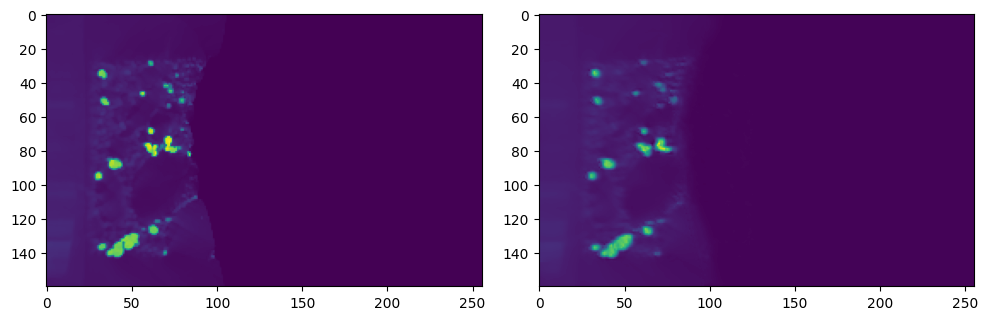

In [86]:
idx = 10
plt.figure(figsize=(10,5))
plt.subplot( 121 ) 
plt.imshow( x_out[idx, ..., 0] )
plt.subplot( 122 ) 
plt.imshow( preds[0][idx, ..., 0] )
plt.tight_layout()